### 4.4.3. 텍스트 분류

IMDB 영화평 데이터셋 주소

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [1]:
using CSV, DataFrames
import MLUtils
import Flux, Optimisers, Zygote, Functors
using Formatting: printfmtln
using TextAnalysis
using Random: MersenneTwister
ENV["DATADEPS_ALWAYS_ACCEPT"] = true # 필요 데이터 자동 다운로드

true

데이터셋 준비

In [2]:
function prepare_corpus()
    imdb = CSV.read("/home/tyfun/Downloads/IMDB Dataset.csv", DataFrame)
    X = replace.(imdb.review, "<br />" => " ")
    X = X.|> tokenize

    X_crps = Corpus(TokenDocument.(X))
    prepare!(X_crps, strip_corrupt_utf8)
    prepare!(X_crps, strip_case)
    prepare!(X_crps, stem_words)
    prepare!(X_crps, strip_non_letters)
    prepare!(X_crps, strip_articles)
    prepare!(X_crps, strip_prepositions)
    prepare!(X_crps, strip_pronouns)
    prepare!(X_crps, strip_stopwords)

    imdb, X_crps
end

prepare_corpus (generic function with 1 method)

In [3]:
function get_data(num_words, seq_len, batch_size)
    imdb, X_crps = prepare_corpus()
    
    update_lexicon!(X_crps)
    lexi = lexicon(X_crps)
    sorted = map(x -> x[1], sort(collect(lexi), by = x->x[2], rev=true))
    top_words = first(filter(x -> x != "", sorted), num_words)
    word_idx = Dict(x => i + 1 for (i, x) in enumerate(top_words))     
    
    X = map(X_crps) do crp
        idx = map(x -> get(word_idx, x, 0), crp.tokens)
        idx = filter(x -> x != 0, idx)
        if length(idx) > seq_len
            idx[1:seq_len]
        else
            vcat(idx, fill(1, seq_len - length(idx)))
        end
    end
    X = MLUtils.batch(X)
    
    y = ifelse.(imdb.sentiment .== "positive", 1, 0);
    y = Flux.onehotbatch(y, 0:1)

    train, test = MLUtils.splitobs((X, y), at = 0.7);
    train_loader = MLUtils.DataLoader(train, batchsize=batch_size)
    test_loader = MLUtils.DataLoader(test, batchsize=batch_size)
    
    train_loader, test_loader, top_words
end

get_data (generic function with 1 method)

학습, 테스트 함수 (4.2절 함수와 동일)

In [4]:
function train(loader, model, loss_fn, optimizer)
    num_batches = length(loader)
    losses = Float32[]
    Flux.testmode!(model, false)
    for (batch, (X, y)) in enumerate(loader)
        X, y = Flux.gpu(X), Flux.gpu(y)
        grad = Zygote.gradient(m -> loss_fn(m, X, y), model)[1]
        optimizer, model = Optimisers.update(optimizer, model, grad)
        if batch % 100 == 0
            loss = loss_fn(model, X, y)
            printfmtln("[Train] loss: {:.7f} [{:>3d}/{:>3d}]", 
                loss, batch, num_batches)
            push!(losses, loss)
        end
    end
    model, optimizer, losses
end

function test(loader, model, loss_fn)
    num_batches = length(loader)
    Flux.testmode!(model, true)
    acc, tot = 0, 0
    loss = 0f0
    for (X, y) in loader
        X, y = Flux.gpu(X), Flux.gpu(y)
        pred = model(X)
        acc += sum(Flux.onecold(pred) .== Flux.onecold(y))
        tot += batch_size
        loss += loss_fn(model, X, y)
    end
    acc, avg_loss = acc / tot * 100, loss / num_batches
    printfmtln("[Test] Accuracy: {:.1f}, Avg loss: {:.7f}", 
        acc, avg_loss)
    acc, avg_loss
end

test (generic function with 1 method)

어텐션 층

In [5]:
struct Attention
    W1
    W2
    v
end

Attention(h_size; rng) = Attention(
    Flux.Dense(h_size => h_size; init=init(rng)),
    Flux.Dense(h_size => h_size; init=init(rng)),
    Flux.Dense(h_size => 1; init=init(rng))
)

Functors.@functor Attention

function (a::Attention)(hs, q) # hs :(feat, batch, seq), q: (feat, batch)
    attn_sc = dropdims(a.v(tanh.(a.W1(hs) .+ a.W2(q))), dims=1) # (batch, seq)    
    attn_w = Flux.softmax(attn_sc, dims=2)  # (batch, seq)
    hcat([hs[:,i,:]*attn_w[i,:] for i in 1:size(hs,2)]...) # (feat, batch)
end

모델 정의

In [6]:
struct MyRNN
    embed       # 단어 임베딩
    rnn_f1      # 첫번째 BiLSTM의 순방향
    rnn_b1      # 첫번째 BiLSTM의 역방향
    rnn_f2      # 두번째 BiLSTM의 순방향
    rnn_b2      # 두번째 BiLSTM의 역방향
    attn        # 바다나우 어텐션
    dense1      # 밀집층 1
    dropout     # 드랍아웃
    dense2      # 밀집층 2
end
Functors.@functor MyRNN

In [7]:
function (a::MyRNN)(X)               # (seq, bat)
    X = a.embed(X)                   # (emb, seq, bat)
    X = permutedims(X, (1,3,2))      # (emb, bat, seq)

    Flux.reset!(a.rnn_f1)
    Flux.reset!(a.rnn_b1)
    Flux.reset!(a.rnn_f2)
    Flux.reset!(a.rnn_b2)
    # 1st BiLSTM
    f = a.rnn_f1(X)                  # (hs, bat, seq)
    f = a.dropout(f)
    b = a.rnn_b1(reverse(X, dims=3)) # (hs, bat, seq)
    b = a.dropout(b)
    X = vcat(f, b)                   # (hs*2, bat, seq)
    # 2nd BiLSTM
    f = a.rnn_f2(X)                  # (hs, bat, seq)
    f = a.dropout(f)
    b = a.rnn_b2(reverse(X, dims=3)) # (hs, bat, seq)
    b = a.dropout(b)
    X = vcat(f, b)                   # (hs*2, bat, seq)
    # attention
    X = a.attn(X, X[:,:,end])        # (hs*2, bat)    
    X = a.dense1(X)
    a.dense2(a.dropout(X))
end

In [8]:
init(rng) = Flux.glorot_uniform(rng)

function build_model(emb; rng, hs = 64)
    embedding = Flux.Embedding(emb)
    embed_size = size(embedding.weight, 1)
    MyRNN(
        embedding,
        Flux.LSTM(embed_size => hs; init=init(rng)), 
        Flux.LSTM(embed_size => hs; init=init(rng)), 
        Flux.LSTM(hs * 2 => hs; init=init(rng)), 
        Flux.LSTM(hs * 2 => hs; init=init(rng)), 
        Attention(hs * 2; rng=rng),
        Flux.Dense(hs * 2 => hs, Flux.relu; init=init(rng)),
        Flux.Dropout(0.5), 
        Flux.Dense(hs => 2; init=init(rng)))
end

build_model (generic function with 1 method)

모델 실행 함수 (4.3.1절 함수와 동일)

In [9]:
function run_batch(loaders, models, epochs)
    train_loader, test_loader = loaders
    loss_fn(m, X, y) = Flux.Losses.logitcrossentropy(m(X), y)
    train_losses, accuracies = [], []
    for (k, model) in enumerate(models)
        train_loss, accuracy = [], []
        optimizer = Optimisers.setup(Optimisers.Adam(), model)
        for t in 1:epochs
            println("[Model $k] Epoch $t")
            println("-------------------------------")
            model, optimizer, loss = 
                train(train_loader, model, loss_fn, optimizer)
            train_loss = vcat(train_loss, loss)
            acc, _ = test(test_loader, model, loss_fn)
            push!(accuracy, acc)
        end
        push!(train_losses, train_loss)
        push!(accuracies, accuracy)
    end
    train_losses, accuracies
end

run_batch (generic function with 1 method)

사전 학습된 임베딩

In [10]:
import Embeddings
function get_glove_embeddings(words)
    emb = Embeddings.load_embeddings(Embeddings.GloVe{:en});
    vocab_dic = Dict(v => i for (i, v) in enumerate(emb.vocab));
    emb_vecs = [haskey(vocab_dic, x) ? 
        emb.embeddings[:, get(vocab_dic, x, 0)] : 
        randn(Float32, 50) for x in words]
    hcat(zeros(Float32, 50), emb_vecs...)    
end

get_glove_embeddings (generic function with 1 method)

In [11]:
num_words = 10000;
seq_len = 300;
batch_size = 64;
embed_size = 50;

train_loader, test_loader, top_words = get_data(num_words, seq_len, batch_size);

rng = MersenneTwister(1)
model_base = build_model(num_words + 1 => embed_size; rng = rng)
model_glove = build_model(get_glove_embeddings(top_words); rng = rng)
models = [model_base, model_glove] .|> Flux.gpu

losses, accus = run_batch((train_loader, test_loader), models, 5)

[Model 1] Epoch 1
-------------------------------


[Train] loss: 0

.6944202 [100/547]


[Train] loss: 0.6410558 [200/547]


[Train] loss: 0.4219030 [300/547]


[Train] loss: 0.3274130 [400/547]


[Train] loss: 0.2798646 [500/547]


[Test] Accuracy: 80.8, Avg loss: 0.4205979
[Model 1] Epoch 2
-------------------------------


[Train] loss: 0.3089064 [100/547]


[Train] loss: 0.3482780 [200/547]


[Train] loss: 0.1810906 [300/547]


[Train] loss: 0.2193991 [400/547]


[Train] loss: 0.1740642 [500/547]


[Test] Accuracy: 85.4, Avg loss: 0.3372928
[Model 1] Epoch 3
-------------------------------


[Train] loss: 0.1631108 [100/547]


[Train] loss: 0.3327086 [200/547]


[Train] loss: 0.1390476 [300/547]


[Train] loss: 0.1871670 [400/547]


[Train] loss: 0.1319586 [500/547]


[Test] Accuracy: 85.7, Avg loss: 0.3356238
[Model 1] Epoch 4
-------------------------------


[Train] loss: 0.1569684 [100/547]


[Train] loss: 0.2390482 [200/547]


[Train] loss: 0.1247870 [300/547]


[Train] loss: 0.1516953 [400/547]


[Train] loss: 0.0747182 [500/547]


[Test] Accuracy: 85.3, Avg loss: 0.3564304
[Model 1] Epoch 5
-------------------------------


[Train] loss: 0.1265992 [100/547]


[Train] loss: 0.2673652 [200/547]


[Train] loss: 0.1554505 [300/547]


[Train] loss: 0.0951110 [400/547]


[Train] loss: 0.0865138 [500/547]


[Test] Accuracy: 85.3, Avg loss: 0.3995043
[Model 2] Epoch 1
-------------------------------


[Train] loss: 0.6005304 [100/547]


[Train] loss: 0.5499192 [200/547]


[Train] loss: 0.3948080 [300/547]


[Train] loss: 0.3524528 [400/547]


[Train] loss: 0.3202396 [500/547]


[Test] Accuracy: 84.6, Avg loss: 0.3563840
[Model 2] Epoch 2
-------------------------------


[Train] loss: 0.3101351 [100/547]


[Train] loss: 0.3356288 [200/547]


[Train] loss: 0.1877252 [300/547]


[Train] loss: 0.2938240 [400/547]


[Train] loss: 0.2012424 [500/547]


[Test] Accuracy: 86.8, Avg loss: 0.3130689
[Model 2] Epoch 3
-------------------------------


[Train] loss: 0.2281278 [100/547]


[Train] loss: 0.2184230 [200/547]


[Train] loss: 0.1417773 [300/547]


[Train] loss: 0.2162776 [400/547]


[Train] loss: 0.1550877 [500/547]


[Test] Accuracy: 87.3, Avg loss: 0.3170323
[Model 2] Epoch 4
-------------------------------


[Train] loss: 0.1848495 [100/547]


[Train] loss: 0.2292268 [200/547]


[Train] loss: 0.1220447 [300/547]


[Train] loss: 0.1566220 [400/547]


[Train] loss: 0.1479174 [500/547]


[Test] Accuracy: 86.9, Avg loss: 0.3470656
[Model 2] Epoch 5
-------------------------------


[Train] loss: 0.1344992 [100/547]


[Train] loss: 0.1919464 [200/547]


[Train] loss: 0.1013235 [300/547]


[Train] loss: 0.1245732 [400/547]


[Train] loss: 0.1627862 [500/547]


[Test] Accuracy: 86.2, Avg loss: 0.4458709


(Any[Any[0.6944202f0, 0.64105576f0, 0.42190298f0, 0.32741296f0, 0.2798646f0, 0.30890635f0, 0.34827796f0, 0.18109062f0, 0.2193991f0, 0.17406416f0  …  0.15696843f0, 0.2390482f0, 0.12478696f0, 0.15169527f0, 0.07471819f0, 0.12659921f0, 0.26736516f0, 0.1554505f0, 0.095110975f0, 0.08651377f0], Any[0.6005304f0, 0.54991925f0, 0.39480805f0, 0.3524528f0, 0.3202396f0, 0.31013507f0, 0.33562875f0, 0.1877252f0, 0.293824f0, 0.20124245f0  …  0.1848495f0, 0.22922684f0, 0.12204467f0, 0.15662196f0, 0.14791745f0, 0.13449924f0, 0.19194642f0, 0.101323515f0, 0.12457323f0, 0.16278616f0]], Any[Any[80.76462765957447, 85.39228723404256, 85.68484042553192, 85.32579787234043, 85.31914893617021], Any[84.6343085106383, 86.7752659574468, 87.26063829787233, 86.89494680851064, 86.21675531914894]])

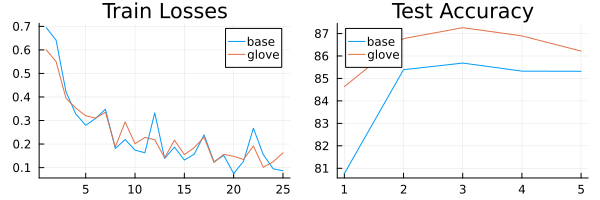

In [12]:
import Plots
Plots.gr(size=(600,200))
label = ["base" "glove"]
title = "Train Losses"
p1 = Plots.plot(losses, label=label, title=title);
title = "Test Accuracy"
p2 = Plots.plot(accus, label=label, title=title);
Plots.plot(p1, p2)